In [30]:
import os
import gc
import re
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from catboost import CatBoostClassifier, Pool
from imblearn.over_sampling import SMOTE

# Suppress PerformanceWarning
warnings.filterwarnings("ignore")


## Load data

Prior to loading the data generated from running Step 1, we identify and categorize columns with string data types in the dataset. Additionally, it selects columns from the 'V' category, focusing on those that exhibit meaningful relationships with the target variable as revealed through correlation-based exploratory data analysis (EDA). By doing so, the code aims to streamline the dataset to include only the most relevant 'V' columns, optimizing computational efficiency and model performance during subsequent analysis and modeling phases. 

In [31]:
# COLUMNS WITH STRINGS
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
str_type += ['id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30', 
            'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']

# FIRST 53 COLUMNS
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# OBTAINED FROM SCRIPT 1
v_cols = ['V1', 'V5', 'V7', 'V8', 'V9', 'V11', 'V13', 'V14', 'V20', 'V24', 'V26', 'V28', 'V30', 
          'V34', 'V36', 'V38', 'V41', 'V45', 'V47', 'V49', 'V52', 'V54', 'V55', 'V56', 'V62', 
          'V65', 'V67', 'V68', 'V70', 'V74', 'V76', 'V78', 'V83', 'V87', 'V88', 'V89', 'V91', 
          'V94', 'V98', 'V100', 'V104', 'V107', 'V109', 'V113', 'V114', 'V116', 'V118', 'V119', 
          'V121', 'V122', 'V124', 'V125', 'V130', 'V131', 'V134', 'V137', 'V281', 'V283', 'V284', 
          'V286', 'V287', 'V289', 'V292', 'V296', 'V297', 'V301', 'V304', 'V305', 'V310', 'V312', 
          'V315', 'V318', 'V321']

cols.extend(v_cols)
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]+\
    ['id-0'+str(x) for x in range(1,10)]+['id-'+str(x) for x in range(10,34)]:
        dtypes[c] = 'float32'
for c in str_type: 
    dtypes[c] = 'category'
    
print('Columns to be read:', cols)

Columns to be read: ['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V5', 'V7', 'V8', 'V9', 'V11', 'V13', 'V14', 'V20', 'V24', 'V26', 'V28', 'V30', 'V34', 'V36', 'V38', 'V41', 'V45', 'V47', 'V49', 'V52', 'V54', 'V55', 'V56', 'V62', 'V65', 'V67', 'V68', 'V70', 'V74', 'V76', 'V78', 'V83', 'V87', 'V88', 'V89', 'V91', 'V94', 'V98', 'V100', 'V104', 'V107', 'V109', 'V113', 'V114', 'V116', 'V118', 'V119', 'V121', 'V122', 'V124', 'V125', 'V130', 'V131', 'V134', 'V137', 'V281', 'V283', 'V284', 'V286', 'V287', 'V289', 'V292', 'V296', 'V297', 'V301', 'V304', 'V305', 'V310', 'V312', 'V315', 'V318', 'V321']


In [32]:
%%time

# LOAD TRAIN
X_train = pd.read_csv('./train_preprocessed.csv',index_col='TransactionID', dtype=dtypes)
# LOAD TEST
X_test = pd.read_csv('./test_preprocessed.csv',index_col='TransactionID', dtype=dtypes)

# TARGET
y_train = X_train['isFraud'].copy()
del X_train['isFraud']; x = gc.collect()

# PRINT STATUS
print('Train shape',X_train.shape,'test shape',X_test.shape)

# DISTRIBUTION OF Y_TRAIN
print(y_train.value_counts())

Train shape (578081, 117) test shape (173242, 117)
isFraud
0    558065
1     20016
Name: count, dtype: int64
CPU times: user 3.16 s, sys: 497 ms, total: 3.66 s
Wall time: 4.02 s


# Normalizing & Converting of D Columns


After looking at the dataset, we realise that the 'D Columns' represent time intervals relative to a specific past reference point. Our objective is to remove time dependence and convert these 'D Columns' into values that correspond to moments in the past rather than future time intervals. This adjustment ensures that the 'D Columns' no longer exhibit an increasing trend over time because we have normalized it against the effects of time. We achieve this transformation using the formula `D15n = Transaction_Day - D15`, where 'Transaction_Day' is calculated as 'TransactionDT' divided by the number of seconds in a day (24 hours * 60 minutes * 60 seconds). Subsequently, we invert the result by multiplying it by -1.

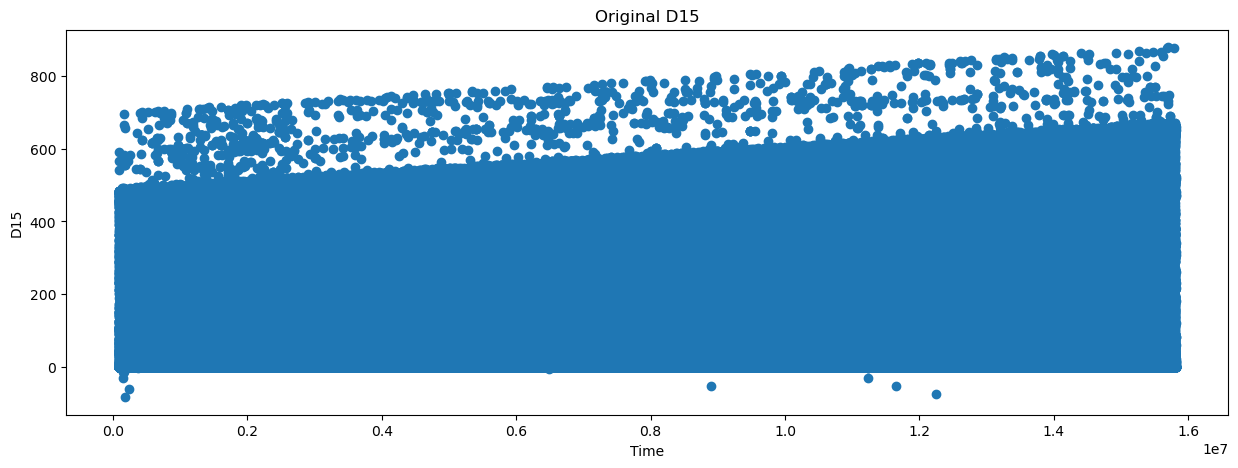

In [33]:
# PLOT ORIGINAL D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Original D15')
plt.xlabel('Time')
plt.ylabel('D15')
plt.show()

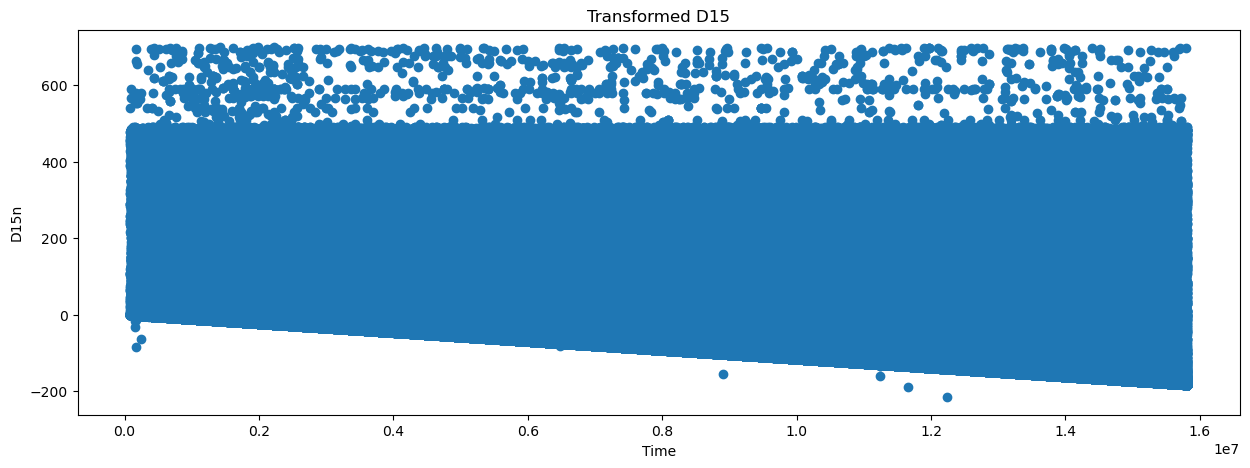

Train shape (578081, 117) test shape (173242, 117)


In [34]:
# NORMALIZE D COLUMNS
for i in range(1,16):
    if i in [1,2,3,5,9]: 
        continue
    # some D columns were dropped in the initial 101 features, so we only preprocess the remaining
    try: 
        X_train['D'+str(i)] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
        X_test['D'+str(i)] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60) 
    except:
        continue
    
# PLOT TRANSFORMED D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Transformed D15')
plt.xlabel('Time')
plt.ylabel('D15n')
plt.show()

print('Train shape',X_train.shape,'test shape',X_test.shape)

# More Preprocessing

Our next step involves the transformation of categorical variables to integers through encoding, the normalization of numeric columns, and addressing any missing data. Given the substantial size of the dataset, we also prioritize memory optimization by ensuring the usage of compatible data types wherever possible. This multi-faceted data preprocessing process aims to enhance the dataset's suitability for analysis and modeling, considering both its size and the type of data it contains.

In [35]:
%%time
# LABEL ENCODE AND MEMORY REDUCE
for i, f in enumerate(X_train.columns):
    # FACTORIZE CATEGORICAL VARIABLES
    if (str(X_train[f].dtype) == 'category') or (X_train[f].dtype == 'object'): 
        df_comb = pd.concat([X_train[f], X_test[f]], axis=0)
        df_comb, _ = df_comb.factorize(sort=True)
        if df_comb.max() > 32000:
            print(f, 'needs int32')
        X_train[f] = df_comb[:len(X_train)].astype('int16')
        X_test[f] = df_comb[len(X_train):].astype('int16')
    # SHIFT ALL NUMERICS POSITIVE. SET NAN to -1
    elif f not in ['TransactionAmt', 'TransactionDT']:
        mn = np.min((X_train[f].min(), X_test[f].min()))
        X_train[f] -= np.float32(mn)
        X_test[f] -= np.float32(mn)
        X_train[f].fillna(-1, inplace=True)
        X_test[f].fillna(-1, inplace=True)

CPU times: user 326 ms, sys: 117 ms, total: 443 ms
Wall time: 487 ms


# Encoding Functions

To address categorical variables, we must identify and consider all categorical variables that are present in both the test and train sets. This comprehensive approach ensures that we encode all relevant categorical variables consistently across the entire dataset.

1) `encode_FE` performs frequency encoding after in combines the train and test set. This allows us to see whether the column values are rare or common. For example, we can use this to check which credit cards are used infrequently.

2) `encode_LE` performs label encoding on the categorical features and converts them into integers. We factorize to reduce memory and turn NAN into -1.

3) `encode_AG` creates aggregated features such as the aggregated mean and std dev. This allows for the model to tell if a row has abnormal values compared to the mean value.

4) `encode_CB` combines two columns together into one column.

5) `encode_AG2` creates more aggregated features where it counts how many unique values of one feature within a group.

In [36]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')
        
# LABEL ENCODE
def encode_LE(col,train=X_train,test=X_test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000: 
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')
        
# GROUP AGGREGATION MEAN AND STD
# https://www.kaggle.com/kyakovlev/ieee-fe-with-some-eda
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=X_train, test_df=X_test, 
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')
                
# COMBINE FEATURES
def encode_CB(col1,col2,df1=X_train,df2=X_test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    df1 = df1.copy()
    df2 = df2.copy()
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')
    
# GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df=X_train, test_df=X_test):
    for main_column in main_columns:  
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')
    train_df = train_df.copy()
    test_df = test_df.copy()

# Feature engineering

In this procedure, we brainstorm potential methods to create new features. Subsequently, we assess each newly generated feature's impact on the Area Under the Curve (AUC) metric. If the addition of a feature leads to an increase in AUC, we retain that feature; otherwise, we eliminate it from consideration. This iterative process helps us identify and incorporate features that enhance model performance while disregarding those that do not contribute positively. The below features are the features that we have thought of that increases the AUC score.

In [37]:
%%time
# TRANSACTION AMT CENTS
X_train['cents'] = (X_train['TransactionAmt'] - np.floor(X_train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')
print('cents, ', end='')

# FREQUENCY ENCODE: ADDR1, CARD1, CARD2, CARD3, P_EMAILDOMAIN
encode_FE(X_train,X_test,['addr1','card1','card2','card3','P_emaildomain'])

# COMBINE COLUMNS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
encode_CB('card1','addr1')
encode_CB('card1_addr1','P_emaildomain')

# FREQUENCY ENOCDE
encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])

# GROUP AGGREGATE
encode_AG(['TransactionAmt','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'],usena=True)
# encode_AG(['TransactionAmt','D9','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'],usena=True)

cents, addr1_FE , card1_FE , card2_FE , card3_FE , P_emaildomain_FE , card1_addr1 , card1_addr1_P_emaildomain , card1_addr1_FE , card1_addr1_P_emaildomain_FE , 'TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 'TransactionAmt_card1_addr1_mean' , 'TransactionAmt_card1_addr1_std' , 'TransactionAmt_card1_addr1_P_emaildomain_mean' , 'TransactionAmt_card1_addr1_P_emaildomain_std' , 'D11_card1_mean' , 'D11_card1_std' , 'D11_card1_addr1_mean' , 'D11_card1_addr1_std' , 'D11_card1_addr1_P_emaildomain_mean' , 'D11_card1_addr1_P_emaildomain_std' , CPU times: user 1.58 s, sys: 487 ms, total: 2.07 s
Wall time: 2.35 s


# Feature selection

Above, we added 23 additional features, bringing the total number of columns to 140, including the index. With this substantial number of features, our goal is to identify the pertinent ones that significantly impact our model's performance. Our chosen evaluation metric is AUC. Therefore, we need to systematically evaluate each feature to ensure that it contributes positively to the model.

Considering that our datasets follow a time sequence, with the test set containing dates that come after the train set, it becomes crucial to ensure that the features exhibit time consistency and remain relevant across different time periods. In this context, the approach to feature selection involves assessing whether a feature maintains its consistency over time independently. Therefore, we will be using time-consistency feature selection. 

While we have explored alternative methods for feature selection, including L1 Regression, Filter methods, and Wrapper methods, our testing has revealed that time-consistency feature selection consistently produces superior results, yielding the highest AUC in our context, be it for local validation or for K-folds, which will be elaborated on in the following sections.

We will be using data from the first 30 days as train data to train the model, and use data from the last 30 days as test data to test the model. Specifically, we want to confirm that each feature yields an AUC score > 0.5 to be considered valuable, if not the feature is not useful as it is worse than random guessing which yields an AUC score of 0.5. Features failing to meet this criterion are considered non-contributory and will be excluded from further consideration.

In [38]:
# Define the start and end timestamps for the first and last months, assuming 30 days in a month
start_timestamp_first_month = X_train['TransactionDT'].min()
end_timestamp_first_month = start_timestamp_first_month + (30 * 24 * 60 * 60)  

start_timestamp_last_month = X_train['TransactionDT'].max() - (30 * 24 * 60 * 60)  
end_timestamp_last_month = X_train['TransactionDT'].max()

# Select rows corresponding to the first month
X_first_month = X_train[(X_train['TransactionDT'] >= start_timestamp_first_month) &
                         (X_train['TransactionDT'] < end_timestamp_first_month)]

# Select rows corresponding to the last month
X_last_month = X_train[(X_train['TransactionDT'] >= start_timestamp_last_month) &
                        (X_train['TransactionDT'] <= end_timestamp_last_month)]

# Extract the indices of rows in X_train that belong to the first month
indices_first_month = (X_train['TransactionDT'] >= start_timestamp_first_month) & (X_train['TransactionDT'] < end_timestamp_first_month)

# Extract the indices of rows in X_train that belong to the last month
indices_last_month = (X_train['TransactionDT'] >= start_timestamp_last_month) & (X_train['TransactionDT'] <= end_timestamp_last_month)

# Use the indices to extract the corresponding y_train entries
y_first_month = y_train[indices_first_month]
y_last_month = y_train[indices_last_month]

In [39]:
%%time
# Create an empty list to store the selected features
selected_features = []

# Define the evaluation threshold (AUC > 0.5)
threshold = 0.5

# Create a tqdm progress bar for the loop
for feature in tqdm(X_train.columns, desc="Processing Features"):
    
    # Train a logistic regression model using only the current feature
    #model = xgb.XGBClassifier()
    model = lgb.LGBMClassifier(verbose=-1)
    model.fit(X_first_month[[feature]], y_first_month)
    
    # Predict on the last month of the training data
    y_pred = model.predict_proba(X_last_month[[feature]])[:, 1]
    
    # Calculate AUC for the validation set
    auc = roc_auc_score(y_last_month, y_pred)
    
    # Check if AUC is above the threshold
    if auc > threshold:
        selected_features.append(feature)

Processing Features: 100%|█████████████████████████████████████████████| 139/139 [00:38<00:00,  3.64it/s]

CPU times: user 3min 41s, sys: 45.8 s, total: 4min 26s
Wall time: 38.2 s


In [40]:
print('Following',len(X_train.columns) - len(selected_features),'features removed:')
print(np.array(set(X_train.columns) - set(selected_features)))
print('#'*70)
print('Following',len(selected_features),'features selected:')
print(np.array(selected_features))

Following 16 features removed:
{'V286', 'TransactionDT', 'V305', 'card4', 'V297', 'M1', 'V1', 'M3', 'V9', 'M2', 'V310', 'addr2', 'V104', 'V107', 'V7', 'V289'}
######################################################################
Following 123 features selected:
['TransactionAmt' 'ProductCD' 'card1' 'card2' 'card3' 'card5' 'card6'
 'addr1' 'dist1' 'P_emaildomain' 'C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8'
 'C9' 'C10' 'C11' 'C12' 'C13' 'C14' 'D1' 'D2' 'D3' 'D4' 'D5' 'D10' 'D11'
 'D15' 'M4' 'M5' 'M6' 'M7' 'M8' 'M9' 'V5' 'V8' 'V11' 'V13' 'V14' 'V20'
 'V24' 'V26' 'V28' 'V30' 'V34' 'V36' 'V38' 'V41' 'V45' 'V47' 'V49' 'V52'
 'V54' 'V55' 'V56' 'V62' 'V65' 'V67' 'V68' 'V70' 'V74' 'V76' 'V78' 'V83'
 'V87' 'V88' 'V89' 'V91' 'V94' 'V98' 'V100' 'V109' 'V113' 'V114' 'V116'
 'V118' 'V119' 'V121' 'V122' 'V124' 'V125' 'V130' 'V131' 'V134' 'V137'
 'V281' 'V283' 'V284' 'V287' 'V292' 'V296' 'V301' 'V304' 'V312' 'V315'
 'V318' 'V321' 'cents' 'addr1_FE' 'card1_FE' 'card2_FE' 'card3_FE'
 'P_emaildomain_FE' 'ca

## Using SMOTE to counter class imbalance

We will be using SMOTE to oversample the minority class, which will be isFraud = 1. Prior to SMOTE, there were 558065 instances of isFraud = 0 and 20016 instances of isFraud = 1. SMOTE introduces 538049 synthetically generated instances of isFraud = 1, bringing the number of instances of isFraud = 1 to be 558065 as well.To preserve the data distribution, ensure an even distribution of the 'isFraud' classes and prevent the possibility of any data leakage into test sets, we will partition our dataset into training and testing sets before applying SMOTE separately to each of these subsets.

In [41]:
# Apply SMOTE to balance the class distribution
from imblearn.over_sampling import SMOTE

# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# print('Original train shape:', X_train.shape, 'Resampled train shape:', X_train_resampled.shape)

# X_train = X_train_resampled
# y_train = y_train_resampled
# del X_train_resampled, y_train_resampled; x = gc.collect()

## Local validation 

We conduct a train-test split, where our model is trained on the first 75% of the dataset and assessed on the remaining 25%. 

During our local validation, we observed that the model achieved an AUC of 0.995, indicating an exceptionally high level of predictive accuracy. However, this seemingly impressive performance raises concerns about potential overfitting, especially in the context of using SMOTE. Overfitting is a common issue associated with SMOTE, as it introduces synthetic data points to balance class distribution. These synthetic data points can closely resemble existing ones and may lead the model to memorize the training data, resulting in overly optimistic validation results.

Moreover, SMOTE may introduce bias by oversampling the minority class, potentially causing the model to become overly sensitive to that class and overlook the nuances of the majority class. This imbalance in synthetic data generation can influence the model's decision boundaries and lead to suboptimal generalization.

To gain a deeper understanding of these challenges, we will investigate feature importance and explore potential reasons for the observed overfitting and bias in our model's performance."

In [42]:
# X_train = pd.concat([X_train,y_train], axis = 1)
# X_train = X_train.sample(frac=1, random_state=42)

# y_train = X_train['isFraud'].copy()
# del X_train['isFraud']

In [43]:
# train split local validation
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

In [44]:
%%time

# lgboost
print("LGBoost version:", lgb.__version__)

# We add the imbalance ratio for our scale_pos_weight
imbalance_ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print('Class imbalanace ratio:', round(imbalance_ratio,4))

clf = lgb.LGBMClassifier(
    boosting_type='gbdt',
    n_estimators=2000,
    max_depth=12,
    learning_rate=0.02,
    subsample=0.8,
    colsample_bytree=0.4,
    metric='auc',
    n_jobs=8,
    random_state=42
)
# Create the log_evaluation callback
callbacks = [
    lgb.early_stopping(100),
    lgb.callback.log_evaluation(period=100)  # Add this callback for verbosity
]

# Splitting dataset before applying SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.loc[idxT, selected_features], y_train.loc[idxT])
X_valid_resampled, y_valid_resampled = smote.fit_resample(X_train.loc[idxV, selected_features], y_train.loc[idxV])

# Fit the model with callbacks
h = clf.fit(
    X_train_resampled,y_train_resampled,
    eval_set=[(X_valid_resampled, y_valid_resampled)],
    callbacks=callbacks  # Use the callbacks argument for controlling verbosity
)



LGBoost version: 3.3.5
Class imbalanace ratio: 27.8809
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.974187
[200]	valid_0's auc: 0.982751
[300]	valid_0's auc: 0.987417
[400]	valid_0's auc: 0.990009
[500]	valid_0's auc: 0.991293
[600]	valid_0's auc: 0.992066
[700]	valid_0's auc: 0.992658
[800]	valid_0's auc: 0.993133
[900]	valid_0's auc: 0.99345
[1000]	valid_0's auc: 0.993722
[1100]	valid_0's auc: 0.993919
[1200]	valid_0's auc: 0.99412
[1300]	valid_0's auc: 0.994281
[1400]	valid_0's auc: 0.994424
[1500]	valid_0's auc: 0.99452
[1600]	valid_0's auc: 0.994632
[1700]	valid_0's auc: 0.994729
[1800]	valid_0's auc: 0.994847
[1900]	valid_0's auc: 0.994925
[2000]	valid_0's auc: 0.995012
Did not meet early stopping. Best iteration is:
[1978]	valid_0's auc: 0.995015
CPU times: user 13min 35s, sys: 1min 49s, total: 15min 24s
Wall time: 2min 19s


In [45]:
# Predict probabilities for the positive class (class 1)
y_pred_proba = clf.predict_proba(X_valid_resampled)[:, 1]
pred_threshold = 0.3

# Convert probabilities to binary predictions based on a threshold (e.g., 0.5)
y_pred = (y_pred_proba >= pred_threshold).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_valid_resampled, y_pred)
precision = precision_score(y_valid_resampled, y_pred)
recall = recall_score(y_valid_resampled, y_pred)
f1 = f1_score(y_valid_resampled, y_pred)
roc_auc = roc_auc_score(y_valid_resampled, y_pred_proba)
confusion = confusion_matrix(y_valid_resampled, y_pred)

# Print the evaluation metrics and confusion matrix
print('ROC AUC Score:', roc_auc,'\n')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Confusion Matrix:')
print(confusion)
print('#'*20,'\n')

ROC AUC Score: 0.9950152295786918 

Accuracy: 0.9729471126624284
Precision: 0.9898593975027096
Recall: 0.9556847258158153
F1 Score: 0.9724719121610041
Confusion Matrix:
[[138157   1366]
 [  6183 133340]]
#################### 



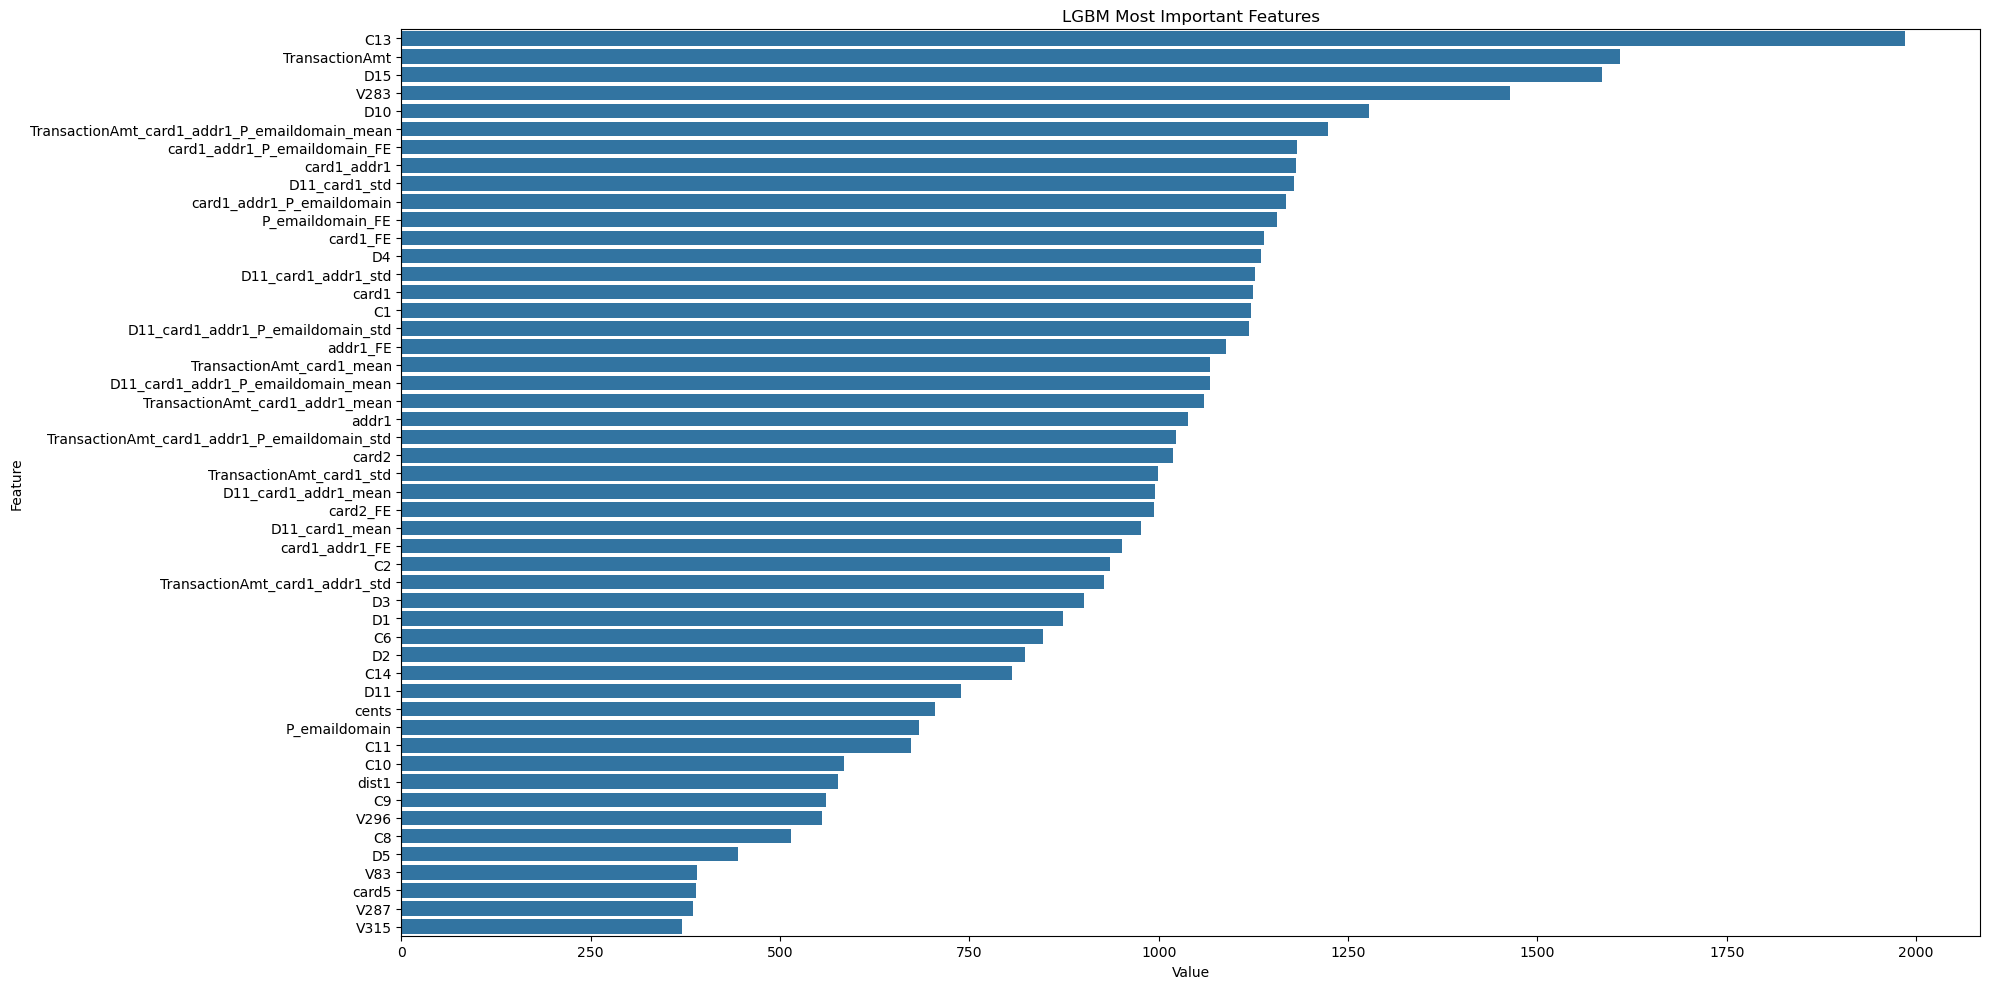

In [46]:
# Create a DataFrame to store feature importances
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,selected_features)), columns=['Value','Feature'])

# Create a figure for the barplot
plt.figure(figsize=(20, 10))

# Create a barplot of the top 50 most important features
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])

# Set the title and adjust layout
plt.title('LGBM Most Important Features')
plt.tight_layout()

# Display the plot
plt.show()

# Clean up and free memory
del clf, h; x = gc.collect()

# Improvement : Adding of userID(UID) to datasets

Due to the dataset's inherent characteristics, wherein once a client's credit card is associated with fraud, all the transactions within their entire account is categorised as fraud. Thus, this makes it imperative to perform essential preprocessing to identify distinct clients. Failing to do so would lead to inaccurate predictions of fraudulent transactions, as not all transactions flagged as fraud are necessarily fraudulent. Hence, in the following step, to improve our model, we will be creating UID which will allow us to identify clients using the columns card_1, addr_1 and D1.

The UID we've generated isn't flawless, as it includes 3118 UIDs containing both fraudulent and non-fraudulent transactions, which encompasses about 1.4% of all the UIDs generated. This suggests the presence of multiple clients within certain UIDs, though this is a relatively small occurrence within our dataset. However, given that we employ LGB, a tree-based model, it possesses the capability to split and partition its feature space to accommodate this variation. Consequently, our model can effectively separate these UIDs and identify individual clients within them.

Understanding our data: https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203

In [47]:
X_train['day'] = X_train.TransactionDT / (24*60*60)
X_train['uid'] = X_train.card1_addr1.astype(str)+'_'+np.floor(X_train.day-X_train.D1).astype(str)
X_train = X_train.copy()

X_test['day'] = X_test.TransactionDT / (24*60*60)
X_test['uid'] = X_test.card1_addr1.astype(str)+'_'+np.floor(X_test.day-X_test.D1).astype(str)
X_test = X_test.copy()

In [48]:
# Check for number of UIDs that contain more than one client inside
df = pd.concat([X_train, y_train], axis=1)
x = df.groupby('uid')['isFraud'].apply(lambda x: x.nunique() == 1)
false_entries = x[~x]

print('Total number of UIDs generated:', len(x))
print('Number of UIDs with more than one client inside:', len(false_entries))
print('Percent of bad UIDs:', round(len(false_entries)/len(x)*100,4),'%')

del df,x; x=gc.collect()

Total number of UIDs generated: 212608
Number of UIDs with more than one client inside: 3073
Percent of bad UIDs: 1.4454 %


## Group aggregated features

To incorporate the UID into our model, we must generate certain aggregated group features. However, once we've created these aggregated features, we exclude the UID from our model. This is because the UID, much like the transactionID, doesn't contribute to the model's predictive capabilities.

In [49]:
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
X_train['DT_M'] = X_train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_train['DT_M'] = (X_train['DT_M'].dt.year-2017)*12 + X_train['DT_M'].dt.month 
X_train = X_train.copy()

X_test['DT_M'] = X_test['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_test['DT_M'] = (X_test['DT_M'].dt.year-2017)*12 + X_test['DT_M'].dt.month 
X_test = X_test.copy()

In [50]:
%%time
# FREQUENCY ENCODE UID
encode_FE(X_train,X_test,['uid'])
# AGGREGATE 
encode_AG(['TransactionAmt','D4','D10','D15'],['uid'],['mean','std'],train_df=X_train, test_df=X_test, fillna=True,usena=True)
# encode_AG(['TransactionAmt','D4','D9','D10','D15'],['uid'],['mean','std'],train_df=X_train, test_df=X_test, fillna=True,usena=True)
# AGGREGATE
encode_AG(['C'+str(x) for x in range(1,15) if x!=3],['uid'],['mean'],train_df=X_train, test_df=X_test,fillna=True,usena=True)
# AGGREGATE
encode_AG(['M'+str(x) for x in range(1,10)],['uid'],['mean'],train_df=X_train, test_df=X_test, fillna=True,usena=True)
# AGGREGATE
encode_AG2(['P_emaildomain','dist1','DT_M','cents'], ['uid'], train_df=X_train, test_df=X_test)
# encode_AG2(['P_emaildomain','dist1','DT_M','id_02','cents'], ['uid'], train_df=X_train, test_df=X_test)
# AGGREGATE
encode_AG(['C14'],['uid'],['std'],train_df=X_train, test_df=X_test,fillna=True,usena=True)
# AGGREGATE 
encode_AG2(['C13','V134','V137','V312','V315','V318','V321'], ['uid'], train_df=X_train, test_df=X_test)
# NEW FEATURE
X_train['outsider15'] = (np.abs(X_train.D1-X_train.D15)>3).astype('int8')
X_test['outsider15'] = (np.abs(X_test.D1-X_test.D15)>3).astype('int8')
print('outsider15')

uid_FE , 'TransactionAmt_uid_mean' , 'TransactionAmt_uid_std' , 'D4_uid_mean' , 'D4_uid_std' , 'D10_uid_mean' , 'D10_uid_std' , 'D15_uid_mean' , 'D15_uid_std' , 'C1_uid_mean' , 'C2_uid_mean' , 'C4_uid_mean' , 'C5_uid_mean' , 'C6_uid_mean' , 'C7_uid_mean' , 'C8_uid_mean' , 'C9_uid_mean' , 'C10_uid_mean' , 'C11_uid_mean' , 'C12_uid_mean' , 'C13_uid_mean' , 'C14_uid_mean' , 'M1_uid_mean' , 'M2_uid_mean' , 'M3_uid_mean' , 'M4_uid_mean' , 'M5_uid_mean' , 'M6_uid_mean' , 'M7_uid_mean' , 'M8_uid_mean' , 'M9_uid_mean' , uid_P_emaildomain_ct, uid_dist1_ct, uid_DT_M_ct, uid_cents_ct, 'C14_uid_std' , uid_C13_ct, uid_V134_ct, uid_V137_ct, uid_V312_ct, uid_V315_ct, uid_V318_ct, uid_V321_ct, outsider15
CPU times: user 23.4 s, sys: 1.25 s, total: 24.7 s
Wall time: 25.5 s


## Feature selection

We perform feature selection again on the dataset as we did before.

In [51]:
# Define the start and end timestamps for the first and last months, assuming 30 days in a month
start_timestamp_first_month = X_train['TransactionDT'].min()
end_timestamp_first_month = start_timestamp_first_month + (30 * 24 * 60 * 60)  

start_timestamp_last_month = X_train['TransactionDT'].max() - (30 * 24 * 60 * 60)  
end_timestamp_last_month = X_train['TransactionDT'].max()

# Select rows corresponding to the first month
X_first_month = X_train[(X_train['TransactionDT'] >= start_timestamp_first_month) &
                         (X_train['TransactionDT'] < end_timestamp_first_month)]

# Select rows corresponding to the last month
X_last_month = X_train[(X_train['TransactionDT'] >= start_timestamp_last_month) &
                        (X_train['TransactionDT'] <= end_timestamp_last_month)]

# Extract the indices of rows in X_train that belong to the first month
indices_first_month = (X_train['TransactionDT'] >= start_timestamp_first_month) & (X_train['TransactionDT'] < end_timestamp_first_month)

# Extract the indices of rows in X_train that belong to the last month
indices_last_month = (X_train['TransactionDT'] >= start_timestamp_last_month) & (X_train['TransactionDT'] <= end_timestamp_last_month)

# Use the indices to extract the corresponding y_train entries
y_first_month = y_train[indices_first_month]
y_last_month = y_train[indices_last_month]

In [52]:
%%time
# Create an empty list to store the selected features
selected_features = []

# Define the evaluation threshold (AUC > 0.5)
threshold = 0.5
X_train = X_train.drop('uid', axis=1)

# Create a tqdm progress bar for the loop
for feature in tqdm(X_train.columns, desc="Processing Features"):
    
    # Train a logistic regression model using only the current feature
    #model = xgb.XGBClassifier()
    model = lgb.LGBMClassifier(verbose=-1)
    model.fit(X_first_month[[feature]], y_first_month)
    
    # Predict on the last month of the training data
    y_pred = model.predict_proba(X_last_month[[feature]])[:, 1]
    
    # Calculate AUC for the validation set
    auc = roc_auc_score(y_last_month, y_pred)
    
    # Check if AUC is above the threshold
    if auc > threshold:
        selected_features.append(feature)

Processing Features: 100%|█████████████████████████████████████████████| 185/185 [01:00<00:00,  3.04it/s]

CPU times: user 5min 48s, sys: 1min 7s, total: 6min 55s
Wall time: 1min 1s


In [53]:
print('Following',len(X_train.columns) - len(selected_features),'features removed:')
print(np.array(set(X_train.columns) - set(selected_features)))
print('#'*70)
print('Following',len(selected_features),'features selected:')
print(np.array(selected_features))

Following 21 features removed:
{'DT_M', 'V297', 'M3', 'M1_uid_mean', 'V286', 'M1', 'V7', 'V289', 'TransactionDT', 'V305', 'card4', 'V1', 'outsider15', 'V9', 'day', 'V310', 'D4_uid_mean', 'addr2', 'V104', 'V107', 'M2'}
######################################################################
Following 164 features selected:
['TransactionAmt' 'ProductCD' 'card1' 'card2' 'card3' 'card5' 'card6'
 'addr1' 'dist1' 'P_emaildomain' 'C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8'
 'C9' 'C10' 'C11' 'C12' 'C13' 'C14' 'D1' 'D2' 'D3' 'D4' 'D5' 'D10' 'D11'
 'D15' 'M4' 'M5' 'M6' 'M7' 'M8' 'M9' 'V5' 'V8' 'V11' 'V13' 'V14' 'V20'
 'V24' 'V26' 'V28' 'V30' 'V34' 'V36' 'V38' 'V41' 'V45' 'V47' 'V49' 'V52'
 'V54' 'V55' 'V56' 'V62' 'V65' 'V67' 'V68' 'V70' 'V74' 'V76' 'V78' 'V83'
 'V87' 'V88' 'V89' 'V91' 'V94' 'V98' 'V100' 'V109' 'V113' 'V114' 'V116'
 'V118' 'V119' 'V121' 'V122' 'V124' 'V125' 'V130' 'V131' 'V134' 'V137'
 'V281' 'V283' 'V284' 'V287' 'V292' 'V296' 'V301' 'V304' 'V312' 'V315'
 'V318' 'V321' 'cents' 'addr1_F

## Local validation 

Once again, we perform local validation as in the code above. 

We use train test split by training on first 75% of the train data and predicting 25% of the train data.  Due to XGB's significantly slower performance and high computational demands (LGB took 17 minutes, whereas XGB took 16 hours), we have opted to transition to LGB for the remainder of this notebook's testing phase.

Local validation for LGB with UID achieved an impressive accuracy of 0.9444, surpassing the accuracy of local validation for LGB without UID which is 0.9305. Additionally, an analysis of the most important features in the LGB classifier revealed that seven of the top eight features are in fact the newly generated aggregated features associated with UID.

In [54]:
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

In [55]:
%%time

# lgboost
print("LGBoost version:", lgb.__version__)

clf = lgb.LGBMClassifier(
    boosting_type='gbdt',
    n_estimators=2000,
    max_depth=12,
    learning_rate=0.02,
    subsample=0.8,
    colsample_bytree=0.4,
    metric='auc',
    n_jobs=8,
    random_state=42
)

# Create the log_evaluation callback
callbacks = [
    lgb.early_stopping(100),
    lgb.callback.log_evaluation(period=100)  # Add this callback for verbosity
]

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.loc[idxT, selected_features], y_train.loc[idxT])
X_valid_resampled, y_valid_resampled = smote.fit_resample(X_train.loc[idxV, selected_features], y_train.loc[idxV])

# Fit the model with callbacks
h = clf.fit(
    X_train_resampled,y_train_resampled,
    eval_set=[(X_valid_resampled, y_valid_resampled)],
    callbacks=callbacks  # Use the callbacks argument for controlling verbosity
)


LGBoost version: 3.3.5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.975432
[200]	valid_0's auc: 0.984514
[300]	valid_0's auc: 0.989592
[400]	valid_0's auc: 0.992023
[500]	valid_0's auc: 0.993301
[600]	valid_0's auc: 0.994131
[700]	valid_0's auc: 0.994564
[800]	valid_0's auc: 0.994859
[900]	valid_0's auc: 0.995114
[1000]	valid_0's auc: 0.995289
[1100]	valid_0's auc: 0.995429
[1200]	valid_0's auc: 0.995564
[1300]	valid_0's auc: 0.995668
[1400]	valid_0's auc: 0.995687
[1500]	valid_0's auc: 0.995731
[1600]	valid_0's auc: 0.99579
[1700]	valid_0's auc: 0.995821
[1800]	valid_0's auc: 0.995843
[1900]	valid_0's auc: 0.995888
[2000]	valid_0's auc: 0.995946
Did not meet early stopping. Best iteration is:
[1999]	valid_0's auc: 0.995946
CPU times: user 18min 56s, sys: 2min 10s, total: 21min 6s
Wall time: 3min 15s


In [56]:
# Predict probabilities for the positive class (class 1)
y_pred_proba = clf.predict_proba(X_valid_resampled)[:, 1]
pred_threshold = 0.3

# Convert probabilities to binary predictions based on a threshold (e.g., 0.5)
y_pred = (y_pred_proba >= pred_threshold).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_valid_resampled, y_pred)
precision = precision_score(y_valid_resampled, y_pred)
recall = recall_score(y_valid_resampled, y_pred)
f1 = f1_score(y_valid_resampled, y_pred)
roc_auc = roc_auc_score(y_valid_resampled, y_pred_proba)
confusion = confusion_matrix(y_valid_resampled, y_pred)

# Print the evaluation metrics and confusion matrix
print('ROC AUC Score:', roc_auc,'\n')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Confusion Matrix:')
print(confusion)
print('#'*20,'\n')

ROC AUC Score: 0.9959462611727229 

Accuracy: 0.9766920149366054
Precision: 0.9890008896339266
Recall: 0.9641062763845387
F1 Score: 0.9763949276677288
Confusion Matrix:
[[138027   1496]
 [  5008 134515]]
#################### 



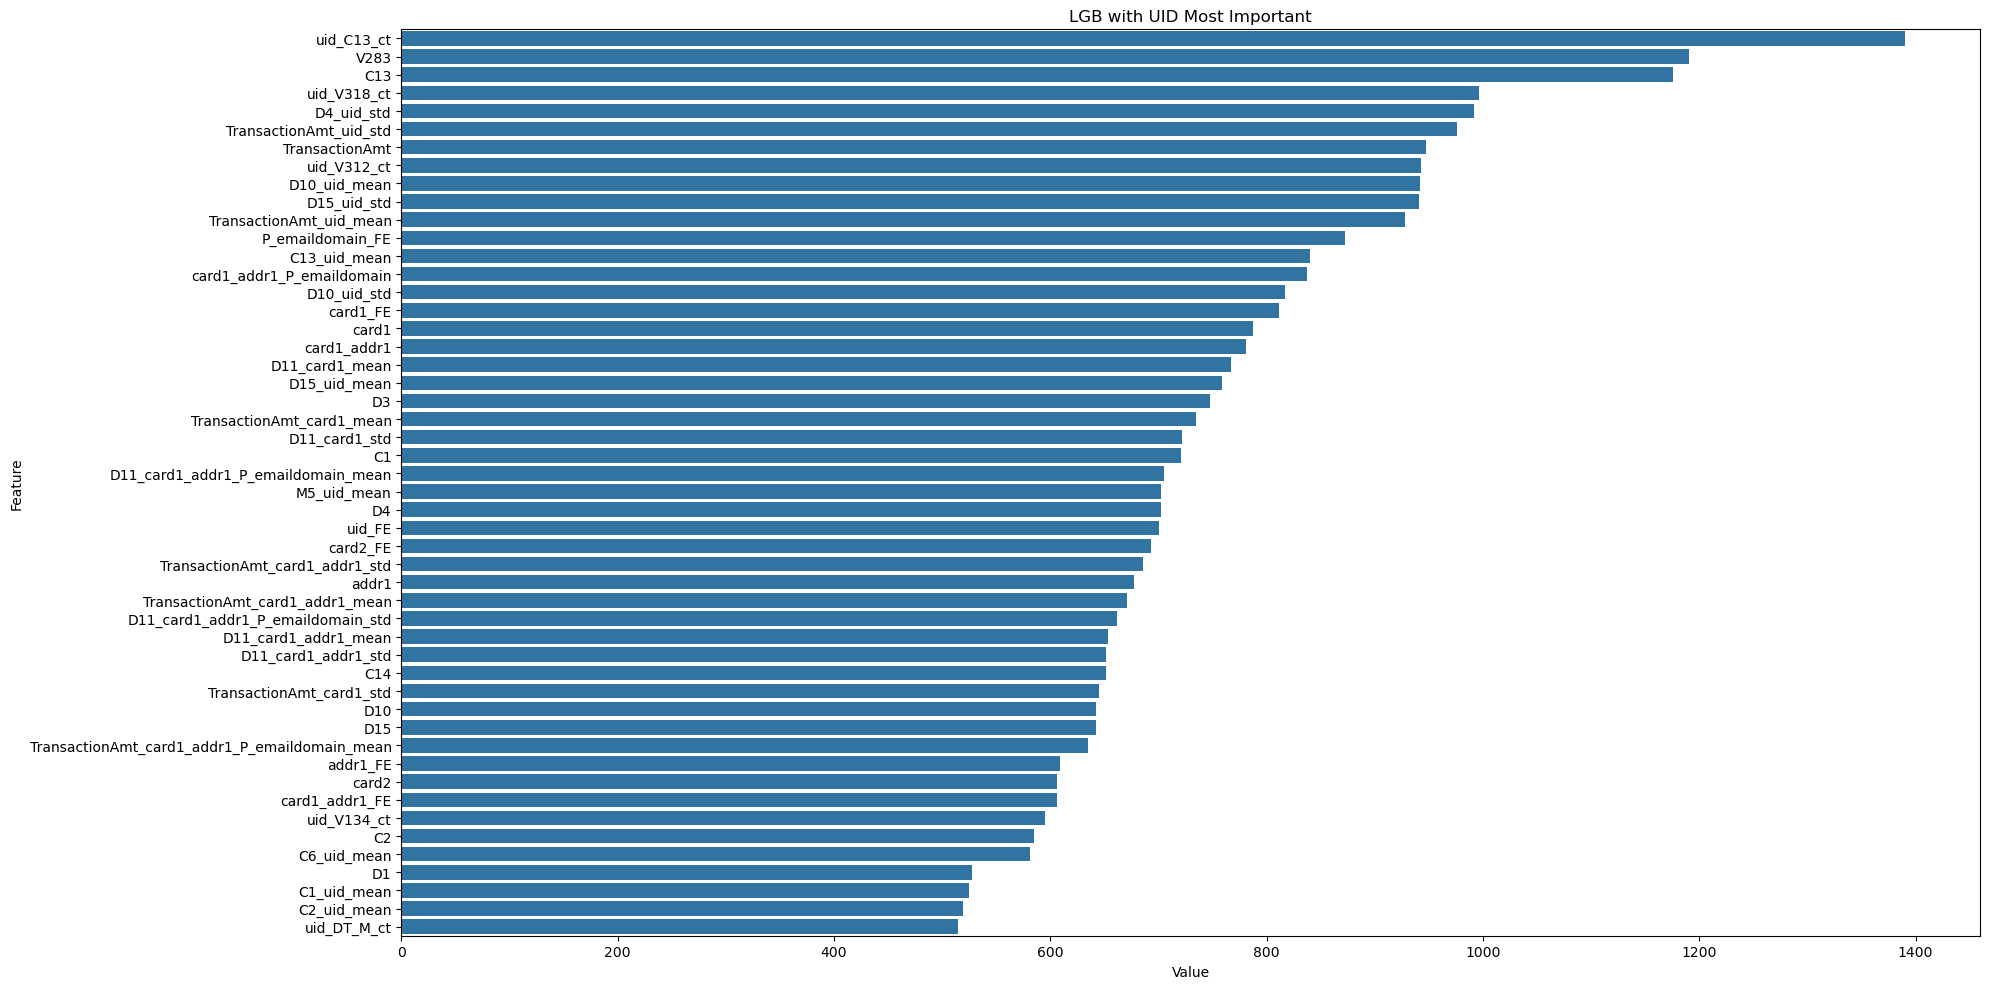

In [57]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,selected_features)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
plt.title('LGB with UID Most Important')
plt.tight_layout()
plt.show()

# Conclusion

The utilization of SMOTE led to an exceptionally high AUC of 0.995 for non UID model and 0.996 for UID model. The F1 Score is also extremely high at 0.972 for non UID and 0.976 for UID. This outcome appears highly improbable, surpassing the performance of the first place model in the Kaggle competition by a large margin, which achieved an AUC of 0.96. Consequently, we have reason to suspect that SMOTE may have induced overfitting of our data points, resulting in the model's inflated AUC and F1 score.